## Neural Networks - Score: 0.88487

Validation set not used in final model training. Layers 500, 250. 

In [1]:
from pandas.api.types import is_string_dtype, is_numeric_dtype, is_categorical_dtype
from fastai.tabular.all import *
from sklearn.metrics import roc_auc_score

pd.options.display.max_rows = 20
pd.options.display.max_columns = 100

### Process Data

In [2]:
# define path to data
path = URLs.path('march-comp')

In [3]:
# read in training set
df = pd.read_csv(path/'train.csv', low_memory=False)

In [4]:
# drop id col
del df['id']

In [5]:
# define dependent var
dep_var = 'target'

In [6]:
# define continuous & categorical cols
cont,cat = cont_cat_split(df, max_card=9000, dep_var=dep_var)

In [7]:
# create random split for train/validation
splits = RandomSplitter(valid_pct=0.2)(range_of(df))

In [8]:
# create tabularpandas object
procs = [Categorify, Normalize]
to = TabularPandas(df, procs, cat, cont, 
                   y_names=dep_var, y_block=CategoryBlock, splits=splits)

In [9]:
# create dataloader object
dls = to.dataloaders(1024)

### Train Neural Net

In [10]:
# create learner
learn = tabular_learner(dls, layers=[500,250], metrics=accuracy)

SuggestedLRs(lr_min=0.003981071710586548, lr_steep=0.2089296132326126)

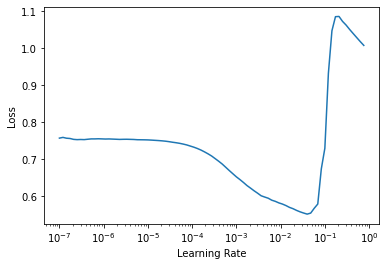

In [11]:
# checking learning rates
learn.lr_find()

In [12]:
# training learner 5 epochs
learn.fit_one_cycle(5, 1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,0.365308,0.375134,0.845183,00:07
1,0.358905,0.356062,0.846117,00:07
2,0.352124,0.352664,0.847333,00:07
3,0.342501,0.350027,0.848600,00:07
4,0.334179,0.351005,0.847950,00:07


In [13]:
# get predictions on validation set
preds,targs = learn.get_preds()

In [21]:
# get probability = 1
preds = preds[:,1]

In [22]:
# get auc score for validation set
roc_auc_score(targs, preds)

0.8914713323378485

### Submit Predictions

In [27]:
# read in test set
test = pd.read_csv(path/'test.csv', low_memory=False)

In [28]:
# convert test set to fastai tabular dataloader
# dls = to.dataloaders(bs=1024)
test_dl = dls.test_dl(test, bs=1024)

In [29]:
# checking length of test set & dataloader - make sure same length
len(test), len(test_dl.train.xs)

(200000, 200000)

In [52]:
# get preds for test set
test_preds,test_targs = learn.get_preds(dl=test_dl)

In [53]:
# get probability = 1
sub_y = test_preds[:,1]

In [56]:
# create submission df
submission = pd.DataFrame({"id": test.id,"target": sub_y})

In [57]:
# save submission to csv
submission.to_csv('NN001.csv', index=False)